In [0]:
!pip install -q tensorflow==2.0.0-beta1

In [0]:
import numpy as np
import random as rn

np.random.seed(126)
rn.seed(126)

In [0]:
import os
import random
from collections import deque
import gym
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import losses
from IPython.display import clear_output

In [0]:
env_name = "CartPole-v1"
env = gym.make(env_name)
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
minibatch_size = 32
num_episodes = 2000
memory_size = 2000              # We keep this many memories

In [0]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        # Memories used for sampling, we keep oldest and newest memory_size.
        self.recent_memory = deque(maxlen=2000)
        self.gamma = 0.95                       # Discount rate for future rewards
        self.epsilon = 1.0                      # Initial rate for exploration
        self.epsilon_decay = 0.995              # Multiplier for exploration rate
        self.epsilon_min = 0.01                 # Minimum exploration rate
        self.learning_rate = 0.001              # NN learning rate
        
        self.model = self._build_model()
        self.history = {"huber": [], "mse": []}
        
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(optimizer=Adam(lr=self.learning_rate),
                      loss="mse"
                     )
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.recent_memory.append((state, action, reward, next_state, done))

    def get_action(self, state):
        # Use random exploration for the current rate.
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        # Otherwise use the model to predict the rewards and select the max.
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
    
    def replay(self):
        if len(self.recent_memory) < minibatch_size:
            return
        
        minibatch = random.sample(self.recent_memory, minibatch_size)
        
        for state, action, reward, next_state, done in minibatch:
            # Get predictions for all actions for the current state.
            q_values = self.model.predict(state)
            
            # If we're not done, add on the future predicted reward at the discounted rate.
            if done:
                q_values[0][action] = reward
            else:
                future_reward = np.amax(self.model.predict(next_state)[0])
                q_values[0][action] = reward + self.gamma * future_reward
            
            self.model.fit(state, q_values, epochs=1, verbose=0)
        
        agent.decay_epsilon()


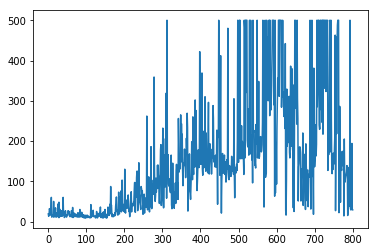

episode: 801/2000, score: 14.0, eps: 0.018, memory: 2000/2000
episode: 802/2000, score: 15.0, eps: 0.018, memory: 2000/2000
episode: 803/2000, score: 21.0, eps: 0.018, memory: 2000/2000
episode: 804/2000, score: 32.0, eps: 0.018, memory: 2000/2000
episode: 805/2000, score: 136.0, eps: 0.018, memory: 2000/2000
episode: 806/2000, score: 30.0, eps: 0.018, memory: 2000/2000
episode: 807/2000, score: 39.0, eps: 0.018, memory: 2000/2000
episode: 808/2000, score: 162.0, eps: 0.018, memory: 2000/2000
episode: 809/2000, score: 107.0, eps: 0.017, memory: 2000/2000


In [0]:
agent = DQNAgent(state_size, action_size)
scores = []

# Why didn't loading work??
#agent.load_weights(os.path.join(output_dir, "weights_xxx.hdf5"))

for episode in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    score = 0
    
    for frame in range(1000):
        # env.render()
        
        action = agent.get_action(state)
        
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        
        agent.remember(state, action, reward, next_state, done)
    
        state = next_state
        score += reward
        
        if done:
            scores.append(score)
            print("episode: {}/{}, score: {}, eps: {:.2}, memory: {}/{}".format(episode, num_episodes, score, agent.epsilon, len(agent.recent_memory), memory_size))
            break
    
    agent.replay()
    
    if episode % 10 == 0 or episode < 10:
        clear_output(wait=True)
        plt.plot(scores)
        plt.show()
    
    #if episode % 100 == 0:
    #    agent.save_weights(os.path.join(output_dir, "weights_{:04d}.hdf5".format(episode)))